In [1]:
import numpy as np
import re
import ast
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import cell_order_log_analysis

In [2]:
FONTSIZE = 16
LINESTYLE = (0,(4,4))
LINEWIDTH = 2.5
SAVE_FIG = True

RESERVATION = 'RES129758'
cell_order_log_filename = '../data/cell-order-' + RESERVATION + '.log'

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period

slice_delay_budget_msec = {0: [60, 90], 1: [30, 50], 2: [5, 15]}

Cell-Order log line:

`2022-10-11 22:06:02,322 INFO     ts_ms:1665525962322 slice_metrics:{0: {'cur_slice_mask': '11111111111000000', 'new_num_rbgs': 5, 'tx_brate downlink [Mbps]': 0.581407, 'dl_mcs': 15.109150000000001, 'num_slice_users': 1, 'dl_latency [msec]': 42767.857142857145, 'dl_buffer [bytes]': 1197.5}, 1: {'cur_slice_mask': '00000000000111000', 'new_num_rbgs': 1, 'tx_brate downlink [Mbps]': 1.8524399999999996, 'dl_mcs': 17.860975, 'num_slice_users': 1, 'dl_latency [msec]': 31.07824910950225, 'dl_buffer [bytes]': 6194.0}, 2: {'cur_slice_mask': '00000000000000110', 'new_num_rbgs': 4, 'tx_brate downlink [Mbps]': 1.6356709999999999, 'dl_mcs': 14.964575, 'num_slice_users': 1, 'dl_latency [msec]': 52.21106831625903, 'dl_buffer [bytes]': 7935.5}}`


In [3]:
data, slice_delay_budget_msec = cell_order_log_analysis.read_cell_order_log(cell_order_log_filename)
cell_order_log_analysis.summarize_over_sla_period(data, SLA_PERIOD, OUTLIER_PERCENTILE)

Data for 1297.4860000610352 seconds has been extracted


Latency budget for slice 0: [60, 90] msec
Latency budget for slice 1: [30, 50] msec
Latency budget for slice 2: [0, 15] msec


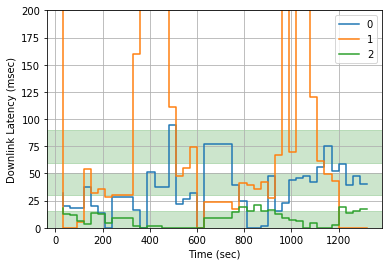

In [4]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['lat_msec'], 
             label=s_idx, where='pre', color='C'+str(s_idx))

for s_idx, budget in slice_delay_budget_msec.items():
    print("Latency budget for slice {}: {} msec".format(s_idx, budget))
    plt.gca().axhspan(budget[0], budget[1], alpha=0.2, color='green')

# plt.yscale('log')
plt.ylim([0,200])

plt.xlabel('Time (sec)')
plt.ylabel('Downlink Latency (msec)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_lat.png')

plt.show()


In [14]:

STAT_ANALYSIS_START_TIME = 660
STAT_ANALYSIS_END_TIME = 3000
cell_order_log_analysis.print_latency_stats(data, 
                                            STAT_ANALYSIS_START_TIME, 
                                            STAT_ANALYSIS_END_TIME, 
                                            slice_delay_budget_msec)


	Latency values for slice 0: ([60,90]: 10.00%) ([55,95]: 20.00%) ([50,100]: 25.00%) (Low-Lat Rate: 100.00%)

[77.45862595 39.08402961 24.59949582  0.          0.          1.67708107
 47.70314129 15.02639702 22.53904744 43.7129702  45.6896567  47.32574928
 41.74711321 55.82831588 75.2237811  52.1827541  58.88578799 39.00300213
 48.05511036 40.34019652]

	Latency values for slice 1: ([30,50]: 30.00%) ([25,55]: 35.00%) ([20,60]: 40.00%) (Low-Lat Rate: 65.00%)

[ 23.99801317  17.22679493  41.63517051  39.66384752  35.75086358
  41.99087177  27.61261354  66.90284857 481.43725241  69.39366516
 375.35910595 286.88710736 120.02615719  61.77534235  49.66689832
  42.99747633   0.           0.           0.           0.        ]

	Latency values for slice 2: ([0,15]: 60.00%) ([0,20]: 95.00%) ([0,25]: 100.00%) (Low-Lat Rate: 60.00%)

[ 8.82989995 14.73700977 19.43370953 15.37565512 20.85867195 15.52623788
 16.39662506 12.82661916  8.98988522  7.47190706  6.42205107  0.
  4.86036617  0.          0.

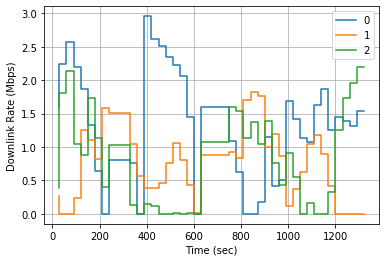

In [6]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['tx_mbps'], 
             label=s_idx, where='pre', color='C'+str(s_idx))

plt.xlabel('Time (sec)')
plt.ylabel('Downlink Rate (Mbps)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_rate.png')

plt.show()

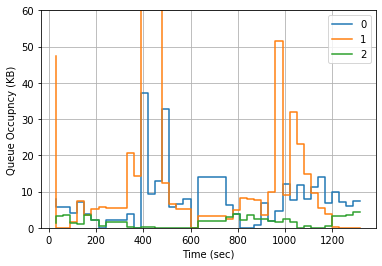

In [7]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['buf_bytes'] / 1e3, 
             label=s_idx, where='pre', color='C'+str(s_idx))

plt.ylim([0,60])

plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupncy (KB)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_buf.png')

plt.show()

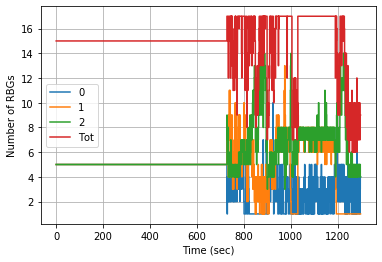

In [8]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['raw_ts_sec'], metrics['raw_n_rbgs'], 
             label=s_idx, where='pre', color='C'+str(s_idx))

cum_n_rbgs = np.zeros_like(data[list(data)[0]]['raw_n_rbgs'])
ts_cum_n_rbgs = data[list(data)[0]]['raw_ts_sec']
max_s_idx = 0
for s_idx, metrics in data.items():
    cur_n_rbgs = metrics['raw_n_rbgs']
    len_diff = len(cur_n_rbgs) - len(cum_n_rbgs)
    if (len_diff > 0):
        cum_n_rbgs = np.append(np.zeros(len_diff).astype(int), cum_n_rbgs)
        ts_cum_n_rbgs = metrics['raw_ts_sec']
    elif (len_diff < 0):
        cur_n_rbgs = np.append(np.zeros(-1*len_diff).astype(int), cur_n_rbgs)
    cum_n_rbgs += cur_n_rbgs
    max_s_idx = max(max_s_idx, s_idx)
plt.step(ts_cum_n_rbgs, cum_n_rbgs, label='Tot', 
         where='pre', color='C'+str(max_s_idx+1))

plt.xlabel('Time (sec)')
plt.ylabel('Number of RBGs')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_rbgs.png')

plt.show()

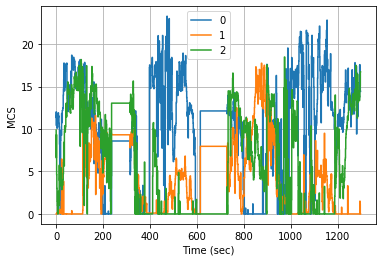

In [13]:
if ('raw_mcs' in data[list(data)[0]].keys()):
    plt.figure()

    for s_idx, metrics in data.items():
        plt.step(metrics['raw_ts_sec'], metrics['raw_mcs'], 
                label=s_idx, where='pre', color='C'+str(s_idx))

    plt.xlabel('Time (sec)')
    plt.ylabel('MCS')
    plt.legend()
    plt.grid()

    if SAVE_FIG:
        plt.savefig('../outputs/' + RESERVATION + '_mcs.png')

    plt.show()

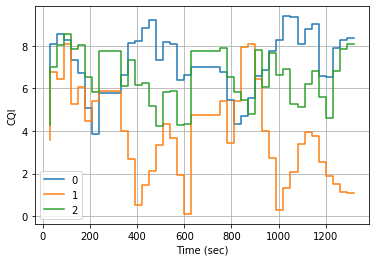

In [12]:
if ('cqi' in data[list(data)[0]].keys()):
    plt.figure()

    for s_idx, metrics in data.items():
        plt.step(metrics['ts_sec'], metrics['cqi'], 
                label=s_idx, where='pre', color='C'+str(s_idx))

    plt.xlabel('Time (sec)')
    plt.ylabel('CQI')
    plt.legend()
    plt.grid()

    if SAVE_FIG:
        plt.savefig('../outputs/' + RESERVATION + '_cqi.png')

    plt.show()